## MLP4

### Neural Network Model

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "NN_deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

(-5.0, 5.0, -1.2, 1.2)

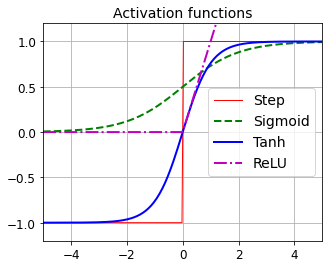

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)


z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

### import tensorflow and keras

In [3]:
import tensorflow as tf
from tensorflow import keras

### Data Loading

In [4]:
# read data from CSV file to dataframe
df = pd.read_csv(r"./input/kc_sales_cleaned.csv")

### Quick view of the data

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     21613 non-null  int64  
 1   id             21613 non-null  int64  
 2   date           21613 non-null  object 
 3   price          21613 non-null  float64
 4   bedrooms       21613 non-null  int64  
 5   bathrooms      21613 non-null  float64
 6   sqft_living    21613 non-null  int64  
 7   sqft_lot       21613 non-null  int64  
 8   floors         21613 non-null  float64
 9   waterfront     21613 non-null  int64  
 10  view           21613 non-null  int64  
 11  condition      21613 non-null  int64  
 12  grade          21613 non-null  int64  
 13  sqft_above     21613 non-null  int64  
 14  sqft_basement  21613 non-null  int64  
 15  yr_built       21613 non-null  int64  
 16  yr_renovated   21613 non-null  int64  
 17  zipcode        21613 non-null  int64  
 18  lat   

### Training and testing datasets

In [6]:
# Import `train_test_split` from `sklearn.model_selection`
from sklearn.model_selection import train_test_split

# Specify the data 

# We use bedrooms, bathrooms, sqft_living, sqft_lot, and 'most_recent' attributes
X = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'most_recent']]
#y = df['price_range']

print(X[:5])

X = X.values

# Specify the target labels and flatten the array
y = np.ravel(df.price_range)

# first 5 row data for X (attributes) and y (class label)
print(X[:10][:5])
print(y[:5])

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

   bedrooms  bathrooms  sqft_living  sqft_lot  most_recent
0         3       1.00         1180      5650         1955
1         3       2.25         2570      7242         1991
2         2       1.00          770     10000         1933
3         4       3.00         1960      5000         1965
4         3       2.00         1680      8080         1987
[[3.000e+00 1.000e+00 1.180e+03 5.650e+03 1.955e+03]
 [3.000e+00 2.250e+00 2.570e+03 7.242e+03 1.991e+03]
 [2.000e+00 1.000e+00 7.700e+02 1.000e+04 1.933e+03]
 [4.000e+00 3.000e+00 1.960e+03 5.000e+03 1.965e+03]
 [3.000e+00 2.000e+00 1.680e+03 8.080e+03 1.987e+03]]
[0 0 0 1 0]


### Standardize the data

In [7]:
# Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler

# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)

## Model Construction

- input layer (5 attributes = 5 units)
- 2 hidden layer (6 units, 6 units)
- output layer (1 unit)

In [8]:
# Initialize the constructor
model = keras.models.Sequential()

# Add the first hidden layer and specify the shape of input layer
model.add(keras.layers.Dense(6, activation='relu', input_shape=(5,)))

# Add 2nd hidden hidden later
model.add(keras.layers.Dense(6, activation='relu'))

# Add an output layer 
model.add(keras.layers.Dense(1, activation='sigmoid'))

### information about the model

In [9]:
# Model output shape
model.output_shape

# Model summary
model.summary()

# Model config
model.get_config()

# List all weight tensors 
model.get_weights()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 36        
                                                                 
 dense_1 (Dense)             (None, 6)                 42        
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________


[array([[-0.7278522 ,  0.39516777,  0.6984039 , -0.4920119 , -0.337887  ,
         -0.66464496],
        [-0.48124105, -0.36120665,  0.20491451,  0.47278756, -0.3931877 ,
          0.39778787],
        [ 0.18836546, -0.57202137,  0.6124014 ,  0.6188167 ,  0.29897672,
          0.06445867],
        [-0.6161871 ,  0.01115721, -0.56249857,  0.10665715,  0.31979316,
          0.09304708],
        [ 0.07144988,  0.01825374,  0.09231353, -0.11506248, -0.5156091 ,
          0.29769975]], dtype=float32),
 array([0., 0., 0., 0., 0., 0.], dtype=float32),
 array([[ 0.3628549 ,  0.30276662, -0.02314639,  0.58831257, -0.69239366,
         -0.12705809],
        [-0.67117846,  0.1740982 , -0.7039798 ,  0.57342035,  0.5087113 ,
         -0.5549258 ],
        [ 0.02520972,  0.3905936 , -0.6821201 , -0.4373595 , -0.06038213,
          0.23486114],
        [ 0.45196456, -0.63454103, -0.46868372,  0.6824338 , -0.0873453 ,
         -0.11414683],
        [ 0.2009911 ,  0.13378507,  0.4838608 ,  0.29133993, 

### compile the model and fit the model to the data

In [10]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
model.fit(X_train, y_train,epochs=3, batch_size=1, verbose=1)

Epoch 1/3
14480/14480 [==============================] - 9s 622us/step - loss: 0.4685 - accuracy: 0.7778
Epoch 2/3
14480/14480 [==============================] - 9s 615us/step - loss: 0.4509 - accuracy: 0.7881
Epoch 3/3
14480/14480 [==============================] - 9s 623us/step - loss: 0.4490 - accuracy: 0.7891


### predict values

In [11]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(y_test[:5])
print(y_pred[:5])

[0 1 1 1 1]
[[0]
 [1]
 [1]
 [1]
 [1]]


### evaluate the model

In [12]:
score = model.evaluate(X_test, y_test,verbose=1)

print(score)

223/223 [==============================] - 0s 658us/step - loss: 0.4397 - accuracy: 0.7952
[0.4396575391292572, 0.7951773405075073]


In [13]:
# Import the modules from `sklearn.metrics`
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

# Confusion matrix
cmatrix = confusion_matrix(y_test, y_pred)

print(cmatrix)

# precision
precision = precision_score(y_test, y_pred)

# Recall
recall = recall_score(y_test, y_pred)

# F1 score
f1 = f1_score(y_test,y_pred)

print('precision: {:.4f}\nrecall: {:.4f}\nf1 score: {:.4f}'.format(precision, recall, f1))

[[3960  552]
 [ 909 1712]]
precision: 0.7562
recall: 0.6532
f1 score: 0.7009


## Find best parameters

### Varying layers

#### Model 1

- input layer (5 attributes = 5 units)
- 2 hidden layers (6 units, 6 units)
- output layer (1 unit)

In [14]:
from sklearn.model_selection import KFold # import k-fold validation

# We use bedrooms, bathrooms, sqft_living, sqft_lot, and 'most_recent' attributes
X = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'most_recent']]
y = df['price_range']

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

target_names = ['Under', 'Over']

# construct a model
model = keras.models.Sequential([
    keras.layers.Dense(6, activation='relu', input_shape=(5,)),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

kf = KFold(n_splits=10, random_state=None, shuffle=True) 
precision_sum = recall_sum = accuracy_sum = 0

# DataFrame for storing validation metrics
metrics_df = pd.DataFrame(columns = ['precision', 'recall', 'accuracy'])

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
    model.fit(X_train, y_train,epochs=3, batch_size=1, verbose=1)
    
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # plot a confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    # classification report
    print(classification_report(y_test, y_pred, target_names=target_names))  
    result_metrics_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    
    precision_sum += result_metrics_dict["macro avg"]["precision"]
    recall_sum += result_metrics_dict["macro avg"]["recall"]
    accuracy_sum += result_metrics_dict["accuracy"]
    
    metrics_list = []
    metrics_list.append(result_metrics_dict["macro avg"]["precision"])
    metrics_list.append(result_metrics_dict["macro avg"]["recall"])
    metrics_list.append(result_metrics_dict["accuracy"])
    
    metrics_series = pd.Series(metrics_list, index=metrics_df.columns)
    metrics_df = metrics_df.append(metrics_series, ignore_index=True)

print("Average precision:", precision_sum/kf.get_n_splits(X))
print("Average recall:", recall_sum/kf.get_n_splits(X))
print("Average accuracy:", accuracy_sum/kf.get_n_splits(X))

os.makedirs('./MLP4_data', exist_ok=True)  
metrics_df.to_csv('./MLP4_data/nn_model1_metrics.csv')

Epoch 1/3
19451/19451 [==============================] - 12s 614us/step - loss: 10.6300 - accuracy: 0.6225
Epoch 2/3
19451/19451 [==============================] - 12s 610us/step - loss: 0.6607 - accuracy: 0.6353
Epoch 3/3
19451/19451 [==============================] - 12s 609us/step - loss: 0.6562 - accuracy: 0.6353
              precision    recall  f1-score   support

       Under       0.62      1.00      0.76      1337
        Over       0.00      0.00      0.00       825

    accuracy                           0.62      2162
   macro avg       0.31      0.50      0.38      2162
weighted avg       0.38      0.62      0.47      2162

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19451/19451 [==============================] - 12s 618us/step - loss: 0.6599 - accuracy: 0.6337
Epoch 2/3
19451/19451 [==============================] - 12s 619us/step - loss: 0.6688 - accuracy: 0.6337
Epoch 3/3
19451/19451 [==============================] - 13s 661us/step - loss: 0.6571 - accuracy: 0.6337
              precision    recall  f1-score   support

       Under       0.63      1.00      0.78      1368
        Over       0.00      0.00      0.00       794

    accuracy                           0.63      2162
   macro avg       0.32      0.50      0.39      2162
weighted avg       0.40      0.63      0.49      2162

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19451/19451 [==============================] - 15s 777us/step - loss: 0.6599 - accuracy: 0.6336
Epoch 2/3
19451/19451 [==============================] - 12s 637us/step - loss: 0.6571 - accuracy: 0.6335
Epoch 3/3
19451/19451 [==============================] - 17s 894us/step - loss: 0.6560 - accuracy: 0.6332
              precision    recall  f1-score   support

       Under       0.63      1.00      0.78      1370
        Over       0.00      0.00      0.00       792

    accuracy                           0.63      2162
   macro avg       0.32      0.50      0.39      2162
weighted avg       0.40      0.63      0.49      2162

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 627us/step - loss: 0.6505 - accuracy: 0.6307
Epoch 2/3
19452/19452 [==============================] - 16s 806us/step - loss: 0.6645 - accuracy: 0.6344
Epoch 3/3
19452/19452 [==============================] - 17s 874us/step - loss: 0.6575 - accuracy: 0.6329
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1382
        Over       0.00      0.00      0.00       779

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 15s 780us/step - loss: 0.6573 - accuracy: 0.6333
Epoch 2/3
19452/19452 [==============================] - 16s 798us/step - loss: 0.6573 - accuracy: 0.6333
Epoch 3/3
19452/19452 [==============================] - 12s 608us/step - loss: 0.6573 - accuracy: 0.6333
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1376
        Over       0.00      0.00      0.00       785

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 13s 628us/step - loss: 0.6569 - accuracy: 0.6342
Epoch 2/3
19452/19452 [==============================] - 17s 881us/step - loss: 0.6569 - accuracy: 0.6342
Epoch 3/3
19452/19452 [==============================] - 12s 612us/step - loss: 0.6568 - accuracy: 0.6342
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1357
        Over       0.00      0.00      0.00       804

    accuracy                           0.63      2161
   macro avg       0.31      0.50      0.39      2161
weighted avg       0.39      0.63      0.48      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 612us/step - loss: 0.6574 - accuracy: 0.6333
Epoch 2/3
19452/19452 [==============================] - 15s 758us/step - loss: 0.6573 - accuracy: 0.6333
Epoch 3/3
19452/19452 [==============================] - 15s 796us/step - loss: 0.6573 - accuracy: 0.6333
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1376
        Over       0.00      0.00      0.00       785

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 626us/step - loss: 0.6574 - accuracy: 0.6331
Epoch 2/3
19452/19452 [==============================] - 18s 936us/step - loss: 0.6574 - accuracy: 0.6331
Epoch 3/3
19452/19452 [==============================] - 12s 614us/step - loss: 0.6575 - accuracy: 0.6331
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1379
        Over       0.00      0.00      0.00       782

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 607us/step - loss: 0.6576 - accuracy: 0.6328
Epoch 2/3
19452/19452 [==============================] - 12s 605us/step - loss: 0.6576 - accuracy: 0.6328
Epoch 3/3
19452/19452 [==============================] - 12s 600us/step - loss: 0.6576 - accuracy: 0.6328
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1385
        Over       0.00      0.00      0.00       776

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 17s 856us/step - loss: 0.6570 - accuracy: 0.6339
Epoch 2/3
19452/19452 [==============================] - 12s 617us/step - loss: 0.6570 - accuracy: 0.6339
Epoch 3/3
19452/19452 [==============================] - 15s 769us/step - loss: 0.6570 - accuracy: 0.6339
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1364
        Over       0.00      0.00      0.00       797

    accuracy                           0.63      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.40      0.63      0.49      2161

Average precision: 0.3168004435709818
Average recall: 0.5
Average accuracy: 0.6336008871419636


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

#### Model 2

- input layer (5 attributes = 5 units)
- 3 hidden layers (6 units)
- output layer (1 unit)

In [15]:
from sklearn.model_selection import KFold # import k-fold validation

# We use bedrooms, bathrooms, sqft_living, sqft_lot, and 'most_recent' attributes
X = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'most_recent']]
y = df['price_range']

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

target_names = ['Under', 'Over']

# construct a model
model = keras.models.Sequential([
    keras.layers.Dense(6, activation='relu', input_shape=(5,)),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

kf = KFold(n_splits=10, random_state=None, shuffle=True) 
precision_sum = recall_sum = accuracy_sum = 0

# DataFrame for storing validation metrics
metrics_df = pd.DataFrame(columns = ['precision', 'recall', 'accuracy'])

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
    model.fit(X_train, y_train,epochs=3, batch_size=1, verbose=1)
    
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # plot a confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    # classification report
    print(classification_report(y_test, y_pred, target_names=target_names))  
    result_metrics_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    
    precision_sum += result_metrics_dict["macro avg"]["precision"]
    recall_sum += result_metrics_dict["macro avg"]["recall"]
    accuracy_sum += result_metrics_dict["accuracy"]
    
    metrics_list = []
    metrics_list.append(result_metrics_dict["macro avg"]["precision"])
    metrics_list.append(result_metrics_dict["macro avg"]["recall"])
    metrics_list.append(result_metrics_dict["accuracy"])
    
    metrics_series = pd.Series(metrics_list, index=metrics_df.columns)
    metrics_df = metrics_df.append(metrics_series, ignore_index=True)

print("Average precision:", precision_sum/kf.get_n_splits(X))
print("Average recall:", recall_sum/kf.get_n_splits(X))
print("Average accuracy:", accuracy_sum/kf.get_n_splits(X))

os.makedirs('./MLP4_data', exist_ok=True)  
metrics_df.to_csv('./MLP4_data/nn_model2_metrics.csv')

Epoch 1/3
19451/19451 [==============================] - 15s 666us/step - loss: 8.8806 - accuracy: 0.6264
Epoch 2/3
19451/19451 [==============================] - 13s 656us/step - loss: 0.6573 - accuracy: 0.6338
Epoch 3/3
19451/19451 [==============================] - 16s 811us/step - loss: 0.6569 - accuracy: 0.6339
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1364
        Over       0.00      0.00      0.00       798

    accuracy                           0.63      2162
   macro avg       0.32      0.50      0.39      2162
weighted avg       0.40      0.63      0.49      2162

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19451/19451 [==============================] - 17s 869us/step - loss: 0.6573 - accuracy: 0.6335
Epoch 2/3
19451/19451 [==============================] - 16s 837us/step - loss: 0.6572 - accuracy: 0.6335
Epoch 3/3
19451/19451 [==============================] - 17s 871us/step - loss: 0.6572 - accuracy: 0.6335
              precision    recall  f1-score   support

       Under       0.63      1.00      0.78      1371
        Over       0.00      0.00      0.00       791

    accuracy                           0.63      2162
   macro avg       0.32      0.50      0.39      2162
weighted avg       0.40      0.63      0.49      2162

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19451/19451 [==============================] - 20s 1000us/step - loss: 0.6565 - accuracy: 0.6344
Epoch 2/3
19451/19451 [==============================] - 17s 866us/step - loss: 0.6568 - accuracy: 0.6344
Epoch 3/3
19451/19451 [==============================] - 14s 735us/step - loss: 0.6567 - accuracy: 0.6344
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1354
        Over       0.00      0.00      0.00       808

    accuracy                           0.63      2162
   macro avg       0.31      0.50      0.39      2162
weighted avg       0.39      0.63      0.48      2162

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 14s 694us/step - loss: 0.6573 - accuracy: 0.6335
Epoch 2/3
19452/19452 [==============================] - 13s 694us/step - loss: 0.6572 - accuracy: 0.6335
Epoch 3/3
19452/19452 [==============================] - 14s 701us/step - loss: 0.6572 - accuracy: 0.6335
              precision    recall  f1-score   support

       Under       0.63      1.00      0.78      1372
        Over       0.00      0.00      0.00       789

    accuracy                           0.63      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.40      0.63      0.49      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 13s 644us/step - loss: 0.6578 - accuracy: 0.6324
Epoch 2/3
19452/19452 [==============================] - 12s 638us/step - loss: 0.6578 - accuracy: 0.6324
Epoch 3/3
19452/19452 [==============================] - 13s 668us/step - loss: 0.6578 - accuracy: 0.6324
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1392
        Over       0.00      0.00      0.00       769

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 13s 630us/step - loss: 0.6570 - accuracy: 0.6338
Epoch 2/3
19452/19452 [==============================] - 13s 643us/step - loss: 0.6571 - accuracy: 0.6338
Epoch 3/3
19452/19452 [==============================] - 13s 664us/step - loss: 0.6571 - accuracy: 0.6338
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1366
        Over       0.00      0.00      0.00       795

    accuracy                           0.63      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.40      0.63      0.49      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 13s 660us/step - loss: 0.6575 - accuracy: 0.6330
Epoch 2/3
19452/19452 [==============================] - 13s 645us/step - loss: 0.6575 - accuracy: 0.6330
Epoch 3/3
19452/19452 [==============================] - 13s 648us/step - loss: 0.6575 - accuracy: 0.6330
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1381
        Over       0.00      0.00      0.00       780

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 13s 651us/step - loss: 0.6570 - accuracy: 0.6339
Epoch 2/3
19452/19452 [==============================] - 13s 668us/step - loss: 0.6570 - accuracy: 0.6339
Epoch 3/3
19452/19452 [==============================] - 13s 668us/step - loss: 0.6569 - accuracy: 0.6339
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1363
        Over       0.00      0.00      0.00       798

    accuracy                           0.63      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.40      0.63      0.49      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 13s 640us/step - loss: 0.6568 - accuracy: 0.6341
Epoch 2/3
19452/19452 [==============================] - 13s 645us/step - loss: 0.6569 - accuracy: 0.6341
Epoch 3/3
19452/19452 [==============================] - 12s 641us/step - loss: 0.6569 - accuracy: 0.6341
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1360
        Over       0.00      0.00      0.00       801

    accuracy                           0.63      2161
   macro avg       0.31      0.50      0.39      2161
weighted avg       0.40      0.63      0.49      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 13s 646us/step - loss: 0.6572 - accuracy: 0.6335
Epoch 2/3
19452/19452 [==============================] - 12s 632us/step - loss: 0.6571 - accuracy: 0.6335
Epoch 3/3
19452/19452 [==============================] - 12s 640us/step - loss: 0.6572 - accuracy: 0.6335
              precision    recall  f1-score   support

       Under       0.63      1.00      0.78      1371
        Over       0.00      0.00      0.00       790

    accuracy                           0.63      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.40      0.63      0.49      2161

Average precision: 0.3168002937448443
Average recall: 0.5
Average accuracy: 0.6336005874896886


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

### Varying number of units (nodes) in hidden layers

#### Model 1

- input layer (5 attributes = 5 units)
- 2 hidden layers (10 units)
- output layer (1 unit)

In [16]:
from sklearn.model_selection import KFold # import k-fold validation

# We use bedrooms, bathrooms, sqft_living, sqft_lot, and 'most_recent' attributes
X = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'most_recent']]
y = df['price_range']

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

target_names = ['Under', 'Over']

# construct a model
model = keras.models.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=(5,)),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

kf = KFold(n_splits=10, random_state=None, shuffle=True) 
precision_sum = recall_sum = accuracy_sum = 0

metrics_df = pd.DataFrame(columns = ['precision', 'recall', 'accuracy'])

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
    model.fit(X_train, y_train,epochs=3, batch_size=1, verbose=1)
    
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # plot a confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    # classification report
    print(classification_report(y_test, y_pred, target_names=target_names))  
    result_metrics_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    
    precision_sum += result_metrics_dict["macro avg"]["precision"]
    recall_sum += result_metrics_dict["macro avg"]["recall"]
    accuracy_sum += result_metrics_dict["accuracy"]
    
    metrics_list = []
    metrics_list.append(result_metrics_dict["macro avg"]["precision"])
    metrics_list.append(result_metrics_dict["macro avg"]["recall"])
    metrics_list.append(result_metrics_dict["accuracy"])
    
    metrics_series = pd.Series(metrics_list, index=metrics_df.columns)
    metrics_df = metrics_df.append(metrics_series, ignore_index=True)

print("Average precision:", precision_sum/kf.get_n_splits(X))
print("Average recall:", recall_sum/kf.get_n_splits(X))
print("Average accuracy:", accuracy_sum/kf.get_n_splits(X))
 
metrics_df.to_csv('./MLP4_data/nn_model3_metrics.csv')

Epoch 1/3
19451/19451 [==============================] - 14s 702us/step - loss: 34.5436 - accuracy: 0.6523
Epoch 2/3
19451/19451 [==============================] - 13s 676us/step - loss: 0.6628 - accuracy: 0.6315
Epoch 3/3
19451/19451 [==============================] - 12s 642us/step - loss: 0.6583 - accuracy: 0.6315
              precision    recall  f1-score   support

       Under       0.65      1.00      0.79      1410
        Over       0.00      0.00      0.00       752

    accuracy                           0.65      2162
   macro avg       0.33      0.50      0.39      2162
weighted avg       0.43      0.65      0.51      2162

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19451/19451 [==============================] - 13s 650us/step - loss: 0.6567 - accuracy: 0.6342
Epoch 2/3
19451/19451 [==============================] - 12s 616us/step - loss: 0.6568 - accuracy: 0.6342
Epoch 3/3
19451/19451 [==============================] - 12s 613us/step - loss: 0.6568 - accuracy: 0.6342
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1358
        Over       0.00      0.00      0.00       804

    accuracy                           0.63      2162
   macro avg       0.31      0.50      0.39      2162
weighted avg       0.39      0.63      0.48      2162

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19451/19451 [==============================] - 14s 627us/step - loss: 0.6569 - accuracy: 0.6341
Epoch 2/3
19451/19451 [==============================] - 12s 613us/step - loss: 0.6569 - accuracy: 0.6341
Epoch 3/3
19451/19451 [==============================] - 12s 615us/step - loss: 0.6569 - accuracy: 0.6341
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1360
        Over       0.00      0.00      0.00       802

    accuracy                           0.63      2162
   macro avg       0.31      0.50      0.39      2162
weighted avg       0.40      0.63      0.49      2162

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 13s 666us/step - loss: 0.6567 - accuracy: 0.6344
Epoch 2/3
19452/19452 [==============================] - 13s 677us/step - loss: 0.6567 - accuracy: 0.6344
Epoch 3/3
19452/19452 [==============================] - 13s 651us/step - loss: 0.6566 - accuracy: 0.6344
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1353
        Over       0.00      0.00      0.00       808

    accuracy                           0.63      2161
   macro avg       0.31      0.50      0.39      2161
weighted avg       0.39      0.63      0.48      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 14s 700us/step - loss: 0.6566 - accuracy: 0.6346
Epoch 2/3
19452/19452 [==============================] - 13s 643us/step - loss: 0.6566 - accuracy: 0.6346
Epoch 3/3
19452/19452 [==============================] - 13s 651us/step - loss: 0.6565 - accuracy: 0.6346
              precision    recall  f1-score   support

       Under       0.62      1.00      0.77      1349
        Over       0.00      0.00      0.00       812

    accuracy                           0.62      2161
   macro avg       0.31      0.50      0.38      2161
weighted avg       0.39      0.62      0.48      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 608us/step - loss: 0.6571 - accuracy: 0.6337
Epoch 2/3
19452/19452 [==============================] - 12s 616us/step - loss: 0.6571 - accuracy: 0.6337
Epoch 3/3
19452/19452 [==============================] - 12s 643us/step - loss: 0.6572 - accuracy: 0.6337
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1367
        Over       0.00      0.00      0.00       794

    accuracy                           0.63      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.40      0.63      0.49      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 610us/step - loss: 0.6568 - accuracy: 0.6342
Epoch 2/3
19452/19452 [==============================] - 12s 637us/step - loss: 0.6568 - accuracy: 0.6342
Epoch 3/3
19452/19452 [==============================] - 12s 614us/step - loss: 0.6569 - accuracy: 0.6342
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1358
        Over       0.00      0.00      0.00       803

    accuracy                           0.63      2161
   macro avg       0.31      0.50      0.39      2161
weighted avg       0.39      0.63      0.49      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 614us/step - loss: 0.6576 - accuracy: 0.6328
Epoch 2/3
19452/19452 [==============================] - 12s 626us/step - loss: 0.6575 - accuracy: 0.6328
Epoch 3/3
19452/19452 [==============================] - 12s 617us/step - loss: 0.6577 - accuracy: 0.6328
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1385
        Over       0.00      0.00      0.00       776

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 626us/step - loss: 0.6576 - accuracy: 0.6327
Epoch 2/3
19452/19452 [==============================] - 13s 661us/step - loss: 0.6577 - accuracy: 0.6327
Epoch 3/3
19452/19452 [==============================] - 12s 625us/step - loss: 0.6576 - accuracy: 0.6327
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1386
        Over       0.00      0.00      0.00       775

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 13s 639us/step - loss: 0.6571 - accuracy: 0.6337
Epoch 2/3
19452/19452 [==============================] - 12s 623us/step - loss: 0.6571 - accuracy: 0.6337
Epoch 3/3
19452/19452 [==============================] - 13s 648us/step - loss: 0.6571 - accuracy: 0.6337
              precision    recall  f1-score   support

       Under       0.63      1.00      0.78      1368
        Over       0.00      0.00      0.00       793

    accuracy                           0.63      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.40      0.63      0.49      2161

Average precision: 0.3167998763720329
Average recall: 0.5
Average accuracy: 0.6335997527440658


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

#### Model 2

- input layer (5 attributes = 5 units)
- 2 hidden layers (15 units)
- output layer (1 unit)

In [17]:
from sklearn.model_selection import KFold # import k-fold validation

# We use bedrooms, bathrooms, sqft_living, sqft_lot, and 'most_recent' attributes
X = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'most_recent']]
y = df['price_range']

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

target_names = ['Under', 'Over']

# construct a model
model = keras.models.Sequential([
    keras.layers.Dense(15, activation='relu', input_shape=(5,)),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

kf = KFold(n_splits=10, random_state=None, shuffle=True) 
precision_sum = recall_sum = accuracy_sum = 0

metrics_df = pd.DataFrame(columns = ['precision', 'recall', 'accuracy'])

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
    model.fit(X_train, y_train,epochs=3, batch_size=1, verbose=1)
    
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # plot a confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    # classification report
    print(classification_report(y_test, y_pred, target_names=target_names))  
    result_metrics_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    
    precision_sum += result_metrics_dict["macro avg"]["precision"]
    recall_sum += result_metrics_dict["macro avg"]["recall"]
    accuracy_sum += result_metrics_dict["accuracy"]
    
    metrics_list = []
    metrics_list.append(result_metrics_dict["macro avg"]["precision"])
    metrics_list.append(result_metrics_dict["macro avg"]["recall"])
    metrics_list.append(result_metrics_dict["accuracy"])
    
    metrics_series = pd.Series(metrics_list, index=metrics_df.columns)
    metrics_df = metrics_df.append(metrics_series, ignore_index=True)

print("Average precision:", precision_sum/kf.get_n_splits(X))
print("Average recall:", recall_sum/kf.get_n_splits(X))
print("Average accuracy:", accuracy_sum/kf.get_n_splits(X))

metrics_df.to_csv('./MLP4_data/nn_model4_metrics.csv')

Epoch 1/3
19451/19451 [==============================] - 14s 685us/step - loss: 42.6243 - accuracy: 0.6868
Epoch 2/3
19451/19451 [==============================] - 13s 677us/step - loss: 0.6741 - accuracy: 0.6493
Epoch 3/3
19451/19451 [==============================] - 13s 687us/step - loss: 0.5792 - accuracy: 0.6905
              precision    recall  f1-score   support

       Under       0.83      0.78      0.80      1398
        Over       0.64      0.72      0.67       764

    accuracy                           0.76      2162
   macro avg       0.74      0.75      0.74      2162
weighted avg       0.76      0.76      0.76      2162

Epoch 1/3
19451/19451 [==============================] - 15s 746us/step - loss: 0.6314 - accuracy: 0.6388
Epoch 2/3
19451/19451 [==============================] - 15s 749us/step - loss: 0.5678 - accuracy: 0.6967
Epoch 3/3
19451/19451 [==============================] - 15s 773us/step - loss: 0.5522 - accuracy: 0.7358
              precision    recall  f

### Varying Activation Functions

#### Model 1

Relu Hidden Layer Activation Function with Sigmoid output layer

- input layer (5 attributes = 5 units)
- 2 hidden layers (6 units)
- output layer (1 unit)

In [14]:
from sklearn.model_selection import KFold # import k-fold validation

# We use bedrooms, bathrooms, sqft_living, sqft_lot, and 'most_recent' attributes
X = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'most_recent']]
y = df['price_range']

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

target_names = ['Under', 'Over']

# construct a model
model = keras.models.Sequential([
    keras.layers.Dense(6, activation='relu', input_shape=(5,)),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

kf = KFold(n_splits=10, random_state=None, shuffle=True) 
precision_sum = recall_sum = accuracy_sum = 0

metrics_df = pd.DataFrame(columns = ['precision', 'recall', 'accuracy'])

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
    model.fit(X_train, y_train,epochs=3, batch_size=1, verbose=1)
    
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # plot a confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    # classification report
    print(classification_report(y_test, y_pred, target_names=target_names))  
    result_metrics_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    
    precision_sum += result_metrics_dict["macro avg"]["precision"]
    recall_sum += result_metrics_dict["macro avg"]["recall"]
    accuracy_sum += result_metrics_dict["accuracy"]
    
    metrics_list = []
    metrics_list.append(result_metrics_dict["macro avg"]["precision"])
    metrics_list.append(result_metrics_dict["macro avg"]["recall"])
    metrics_list.append(result_metrics_dict["accuracy"])
    
    metrics_series = pd.Series(metrics_list, index=metrics_df.columns)
    metrics_df = metrics_df.append(metrics_series, ignore_index=True)

print("Average precision:", precision_sum/kf.get_n_splits(X))
print("Average recall:", recall_sum/kf.get_n_splits(X))
print("Average accuracy:", accuracy_sum/kf.get_n_splits(X))

metrics_df.to_csv('./MLP4_data/nn_model5_metrics.csv')

Epoch 1/3
19451/19451 [==============================] - 12s 611us/step - loss: 12.2390 - accuracy: 0.6187
Epoch 2/3
19451/19451 [==============================] - 12s 607us/step - loss: 0.6562 - accuracy: 0.6353
Epoch 3/3
19451/19451 [==============================] - 12s 616us/step - loss: 0.6563 - accuracy: 0.6353
              precision    recall  f1-score   support

       Under       0.62      1.00      0.76      1337
        Over       0.00      0.00      0.00       825

    accuracy                           0.62      2162
   macro avg       0.31      0.50      0.38      2162
weighted avg       0.38      0.62      0.47      2162

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19451/19451 [==============================] - 12s 618us/step - loss: 0.6569 - accuracy: 0.6337
Epoch 2/3
19451/19451 [==============================] - 12s 605us/step - loss: 0.6571 - accuracy: 0.6337
Epoch 3/3
19451/19451 [==============================] - 12s 606us/step - loss: 0.6572 - accuracy: 0.6337
              precision    recall  f1-score   support

       Under       0.63      1.00      0.78      1368
        Over       0.00      0.00      0.00       794

    accuracy                           0.63      2162
   macro avg       0.32      0.50      0.39      2162
weighted avg       0.40      0.63      0.49      2162

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19451/19451 [==============================] - 12s 606us/step - loss: 0.6572 - accuracy: 0.6336
Epoch 2/3
19451/19451 [==============================] - 12s 617us/step - loss: 0.6572 - accuracy: 0.6336
Epoch 3/3
19451/19451 [==============================] - 12s 607us/step - loss: 0.6571 - accuracy: 0.6336
              precision    recall  f1-score   support

       Under       0.63      1.00      0.78      1370
        Over       0.00      0.00      0.00       792

    accuracy                           0.63      2162
   macro avg       0.32      0.50      0.39      2162
weighted avg       0.40      0.63      0.49      2162

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 606us/step - loss: 0.6575 - accuracy: 0.6329
Epoch 2/3
19452/19452 [==============================] - 12s 603us/step - loss: 0.6575 - accuracy: 0.6329
Epoch 3/3
19452/19452 [==============================] - 12s 601us/step - loss: 0.6575 - accuracy: 0.6329
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1382
        Over       0.00      0.00      0.00       779

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 613us/step - loss: 0.6574 - accuracy: 0.6333
Epoch 2/3
19452/19452 [==============================] - 12s 615us/step - loss: 0.6573 - accuracy: 0.6333
Epoch 3/3
19452/19452 [==============================] - 12s 621us/step - loss: 0.6574 - accuracy: 0.6333
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1376
        Over       0.00      0.00      0.00       785

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 611us/step - loss: 0.6568 - accuracy: 0.6342
Epoch 2/3
19452/19452 [==============================] - 13s 665us/step - loss: 0.6568 - accuracy: 0.6342
Epoch 3/3
19452/19452 [==============================] - 12s 618us/step - loss: 0.6568 - accuracy: 0.6342
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1357
        Over       0.00      0.00      0.00       804

    accuracy                           0.63      2161
   macro avg       0.31      0.50      0.39      2161
weighted avg       0.39      0.63      0.48      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 13s 629us/step - loss: 0.6573 - accuracy: 0.6333
Epoch 2/3
19452/19452 [==============================] - 12s 619us/step - loss: 0.6573 - accuracy: 0.6333
Epoch 3/3
19452/19452 [==============================] - 12s 612us/step - loss: 0.6574 - accuracy: 0.6333
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1376
        Over       0.00      0.00      0.00       785

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 611us/step - loss: 0.6575 - accuracy: 0.6331
Epoch 2/3
19452/19452 [==============================] - 12s 612us/step - loss: 0.6575 - accuracy: 0.6331
Epoch 3/3
19452/19452 [==============================] - 12s 608us/step - loss: 0.6574 - accuracy: 0.6331
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1379
        Over       0.00      0.00      0.00       782

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 617us/step - loss: 0.6576 - accuracy: 0.6328
Epoch 2/3
19452/19452 [==============================] - 12s 614us/step - loss: 0.6576 - accuracy: 0.6328
Epoch 3/3
19452/19452 [==============================] - 12s 612us/step - loss: 0.6577 - accuracy: 0.6328
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1385
        Over       0.00      0.00      0.00       776

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 614us/step - loss: 0.6570 - accuracy: 0.6339
Epoch 2/3
19452/19452 [==============================] - 12s 616us/step - loss: 0.6570 - accuracy: 0.6339
Epoch 3/3
19452/19452 [==============================] - 12s 620us/step - loss: 0.6570 - accuracy: 0.6339
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1364
        Over       0.00      0.00      0.00       797

    accuracy                           0.63      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.40      0.63      0.49      2161

Average precision: 0.3168004435709818
Average recall: 0.5
Average accuracy: 0.6336008871419636


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

#### Model 2

Tanh Hidden Layer Activation Function with Sigmoid output layer

- input layer (5 attributes = 5 units)
- 2 hidden layers (6 units)
- output layer (1 unit)

In [15]:
from sklearn.model_selection import KFold # import k-fold validation

# We use bedrooms, bathrooms, sqft_living, sqft_lot, and 'most_recent' attributes
X = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'most_recent']]
y = df['price_range']

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

target_names = ['Under', 'Over']

# construct a model
model = keras.models.Sequential([
    keras.layers.Dense(6, activation='tanh', input_shape=(5,)),
    keras.layers.Dense(6, activation='tanh'),
    keras.layers.Dense(1, activation='sigmoid')
])

kf = KFold(n_splits=10, random_state=None, shuffle=True) 
precision_sum = recall_sum = accuracy_sum = 0

metrics_df = pd.DataFrame(columns = ['precision', 'recall', 'accuracy'])

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
    model.fit(X_train, y_train,epochs=3, batch_size=1, verbose=1)
    
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # plot a confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    # classification report
    print(classification_report(y_test, y_pred, target_names=target_names))  
    result_metrics_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    
    precision_sum += result_metrics_dict["macro avg"]["precision"]
    recall_sum += result_metrics_dict["macro avg"]["recall"]
    accuracy_sum += result_metrics_dict["accuracy"]
    
    metrics_list = []
    metrics_list.append(result_metrics_dict["macro avg"]["precision"])
    metrics_list.append(result_metrics_dict["macro avg"]["recall"])
    metrics_list.append(result_metrics_dict["accuracy"])
    
    metrics_series = pd.Series(metrics_list, index=metrics_df.columns)
    metrics_df = metrics_df.append(metrics_series, ignore_index=True)

print("Average precision:", precision_sum/kf.get_n_splits(X))
print("Average recall:", recall_sum/kf.get_n_splits(X))
print("Average accuracy:", accuracy_sum/kf.get_n_splits(X))

metrics_df.to_csv('./MLP4_data/nn_model6_metrics.csv')

Epoch 1/3
19451/19451 [==============================] - 13s 609us/step - loss: 0.6540 - accuracy: 0.6331
Epoch 2/3
19451/19451 [==============================] - 12s 613us/step - loss: 0.6539 - accuracy: 0.6335
Epoch 3/3
19451/19451 [==============================] - 12s 636us/step - loss: 0.6565 - accuracy: 0.6337
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1364
        Over       0.00      0.00      0.00       798

    accuracy                           0.63      2162
   macro avg       0.32      0.50      0.39      2162
weighted avg       0.40      0.63      0.49      2162

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19451/19451 [==============================] - 12s 628us/step - loss: 0.6559 - accuracy: 0.6335
Epoch 2/3
19451/19451 [==============================] - 12s 608us/step - loss: 0.6556 - accuracy: 0.6335
Epoch 3/3
19451/19451 [==============================] - 12s 618us/step - loss: 0.6561 - accuracy: 0.6335
              precision    recall  f1-score   support

       Under       0.63      1.00      0.78      1371
        Over       0.00      0.00      0.00       791

    accuracy                           0.63      2162
   macro avg       0.32      0.50      0.39      2162
weighted avg       0.40      0.63      0.49      2162

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19451/19451 [==============================] - 12s 625us/step - loss: 0.6567 - accuracy: 0.6345
Epoch 2/3
19451/19451 [==============================] - 12s 627us/step - loss: 0.6571 - accuracy: 0.6345
Epoch 3/3
19451/19451 [==============================] - 12s 610us/step - loss: 0.6569 - accuracy: 0.6345
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1354
        Over       0.00      0.00      0.00       808

    accuracy                           0.63      2162
   macro avg       0.31      0.50      0.39      2162
weighted avg       0.39      0.63      0.48      2162

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 607us/step - loss: 0.6554 - accuracy: 0.6335
Epoch 2/3
19452/19452 [==============================] - 12s 617us/step - loss: 0.6554 - accuracy: 0.6335
Epoch 3/3
19452/19452 [==============================] - 12s 609us/step - loss: 0.6544 - accuracy: 0.6335
              precision    recall  f1-score   support

       Under       0.63      1.00      0.78      1372
        Over       0.00      0.00      0.00       789

    accuracy                           0.63      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.40      0.63      0.49      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 604us/step - loss: 0.6549 - accuracy: 0.6324
Epoch 2/3
19452/19452 [==============================] - 12s 606us/step - loss: 0.6554 - accuracy: 0.6325
Epoch 3/3
19452/19452 [==============================] - 12s 624us/step - loss: 0.6551 - accuracy: 0.6325
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1392
        Over       0.00      0.00      0.00       769

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 13s 636us/step - loss: 0.6548 - accuracy: 0.6338
Epoch 2/3
19452/19452 [==============================] - 12s 621us/step - loss: 0.6550 - accuracy: 0.6338
Epoch 3/3
19452/19452 [==============================] - 12s 615us/step - loss: 0.6556 - accuracy: 0.6338
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1366
        Over       1.00      0.00      0.00       795

    accuracy                           0.63      2161
   macro avg       0.82      0.50      0.39      2161
weighted avg       0.77      0.63      0.49      2161

Epoch 1/3
19452/19452 [==============================] - 12s 605us/step - loss: 0.6578 - accuracy: 0.6331
Epoch 2/3
19452/19452 [==============================] - 13s 646us/step - loss: 0.6574 - accuracy: 0.6331
Epoch 3/3
19452/19452 [==============================] - 12s 630us/step - loss: 0.6580 - accuracy: 0.6331
              precision    recall  f1-score   s

/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 608us/step - loss: 0.6569 - accuracy: 0.6340
Epoch 2/3
19452/19452 [==============================] - 12s 608us/step - loss: 0.6561 - accuracy: 0.6340
Epoch 3/3
19452/19452 [==============================] - 12s 608us/step - loss: 0.6546 - accuracy: 0.6340
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1363
        Over       0.00      0.00      0.00       798

    accuracy                           0.63      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.40      0.63      0.49      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 608us/step - loss: 0.6549 - accuracy: 0.6342
Epoch 2/3
19452/19452 [==============================] - 12s 617us/step - loss: 0.6547 - accuracy: 0.6342
Epoch 3/3
19452/19452 [==============================] - 12s 609us/step - loss: 0.6551 - accuracy: 0.6342
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1360
        Over       0.00      0.00      0.00       801

    accuracy                           0.63      2161
   macro avg       0.31      0.50      0.39      2161
weighted avg       0.40      0.63      0.49      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 622us/step - loss: 0.6565 - accuracy: 0.6336
Epoch 2/3
19452/19452 [==============================] - 12s 623us/step - loss: 0.6575 - accuracy: 0.6336
Epoch 3/3
19452/19452 [==============================] - 12s 616us/step - loss: 0.6576 - accuracy: 0.6336
              precision    recall  f1-score   support

       Under       0.63      1.00      0.78      1371
        Over       0.00      0.00      0.00       790

    accuracy                           0.63      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.40      0.63      0.49      2161

Average precision: 0.3668149260309944
Average recall: 0.500062893081761
Average accuracy: 0.6336468623624327


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

#### Model 3

Sigmoid Hidden Layer Activation Function with Sigmoid output layer

- input layer (5 attributes = 5 units)
- 2 hidden layers (6 units)
- output layer (1 unit)

In [16]:
from sklearn.model_selection import KFold # import k-fold validation

# We use bedrooms, bathrooms, sqft_living, sqft_lot, and 'most_recent' attributes
X = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'most_recent']]
y = df['price_range']

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

target_names = ['Under', 'Over']

# construct a model
model = keras.models.Sequential([
    keras.layers.Dense(6, activation='sigmoid', input_shape=(5,)),
    keras.layers.Dense(6, activation='sigmoid'),
    keras.layers.Dense(1, activation='sigmoid')
])

kf = KFold(n_splits=10, random_state=None, shuffle=True) 
precision_sum = recall_sum = accuracy_sum = 0

metrics_df = pd.DataFrame(columns = ['precision', 'recall', 'accuracy'])

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
    model.fit(X_train, y_train,epochs=3, batch_size=1, verbose=1)
    
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # plot a confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    # classification report
    print(classification_report(y_test, y_pred, target_names=target_names))  
    result_metrics_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    
    precision_sum += result_metrics_dict["macro avg"]["precision"]
    recall_sum += result_metrics_dict["macro avg"]["recall"]
    accuracy_sum += result_metrics_dict["accuracy"]
    
    metrics_list = []
    metrics_list.append(result_metrics_dict["macro avg"]["precision"])
    metrics_list.append(result_metrics_dict["macro avg"]["recall"])
    metrics_list.append(result_metrics_dict["accuracy"])
    
    metrics_series = pd.Series(metrics_list, index=metrics_df.columns)
    metrics_df = metrics_df.append(metrics_series, ignore_index=True)

print("Average precision:", precision_sum/kf.get_n_splits(X))
print("Average recall:", recall_sum/kf.get_n_splits(X))
print("Average accuracy:", accuracy_sum/kf.get_n_splits(X))

metrics_df.to_csv('./MLP4_data/nn_model7_metrics.csv')

Epoch 1/3
19451/19451 [==============================] - 12s 606us/step - loss: 0.6612 - accuracy: 0.6268
Epoch 2/3
19451/19451 [==============================] - 12s 615us/step - loss: 0.6589 - accuracy: 0.6315
Epoch 3/3
19451/19451 [==============================] - 12s 620us/step - loss: 0.6587 - accuracy: 0.6315
              precision    recall  f1-score   support

       Under       0.65      1.00      0.79      1410
        Over       0.00      0.00      0.00       752

    accuracy                           0.65      2162
   macro avg       0.33      0.50      0.39      2162
weighted avg       0.43      0.65      0.51      2162

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19451/19451 [==============================] - 12s 607us/step - loss: 0.6574 - accuracy: 0.6342
Epoch 2/3
19451/19451 [==============================] - 12s 608us/step - loss: 0.6573 - accuracy: 0.6342
Epoch 3/3
19451/19451 [==============================] - 12s 611us/step - loss: 0.6572 - accuracy: 0.6342
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1358
        Over       0.00      0.00      0.00       804

    accuracy                           0.63      2162
   macro avg       0.31      0.50      0.39      2162
weighted avg       0.39      0.63      0.48      2162

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19451/19451 [==============================] - 12s 611us/step - loss: 0.6573 - accuracy: 0.6341
Epoch 2/3
19451/19451 [==============================] - 12s 602us/step - loss: 0.6571 - accuracy: 0.6341
Epoch 3/3
19451/19451 [==============================] - 12s 604us/step - loss: 0.6570 - accuracy: 0.6341
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1360
        Over       0.00      0.00      0.00       802

    accuracy                           0.63      2162
   macro avg       0.31      0.50      0.39      2162
weighted avg       0.40      0.63      0.49      2162

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 603us/step - loss: 0.6572 - accuracy: 0.6344
Epoch 2/3
19452/19452 [==============================] - 12s 603us/step - loss: 0.6570 - accuracy: 0.6344
Epoch 3/3
19452/19452 [==============================] - 12s 604us/step - loss: 0.6568 - accuracy: 0.6344
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1353
        Over       0.00      0.00      0.00       808

    accuracy                           0.63      2161
   macro avg       0.31      0.50      0.39      2161
weighted avg       0.39      0.63      0.48      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 615us/step - loss: 0.6569 - accuracy: 0.6346
Epoch 2/3
19452/19452 [==============================] - 12s 608us/step - loss: 0.6569 - accuracy: 0.6346
Epoch 3/3
19452/19452 [==============================] - 12s 608us/step - loss: 0.6569 - accuracy: 0.6346
              precision    recall  f1-score   support

       Under       0.62      1.00      0.77      1349
        Over       0.00      0.00      0.00       812

    accuracy                           0.62      2161
   macro avg       0.31      0.50      0.38      2161
weighted avg       0.39      0.62      0.48      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 608us/step - loss: 0.6574 - accuracy: 0.6337
Epoch 2/3
19452/19452 [==============================] - 12s 608us/step - loss: 0.6575 - accuracy: 0.6337
Epoch 3/3
19452/19452 [==============================] - 12s 607us/step - loss: 0.6573 - accuracy: 0.6337
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1367
        Over       0.00      0.00      0.00       794

    accuracy                           0.63      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.40      0.63      0.49      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 608us/step - loss: 0.6570 - accuracy: 0.6342
Epoch 2/3
19452/19452 [==============================] - 13s 664us/step - loss: 0.6571 - accuracy: 0.6342
Epoch 3/3
19452/19452 [==============================] - 12s 610us/step - loss: 0.6571 - accuracy: 0.6342
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1358
        Over       0.00      0.00      0.00       803

    accuracy                           0.63      2161
   macro avg       0.31      0.50      0.39      2161
weighted avg       0.39      0.63      0.49      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 611us/step - loss: 0.6578 - accuracy: 0.6328
Epoch 2/3
19452/19452 [==============================] - 12s 621us/step - loss: 0.6578 - accuracy: 0.6328
Epoch 3/3
19452/19452 [==============================] - 12s 622us/step - loss: 0.6579 - accuracy: 0.6328
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1385
        Over       0.00      0.00      0.00       776

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 622us/step - loss: 0.6579 - accuracy: 0.6327
Epoch 2/3
19452/19452 [==============================] - 12s 614us/step - loss: 0.6578 - accuracy: 0.6327
Epoch 3/3
19452/19452 [==============================] - 12s 613us/step - loss: 0.6577 - accuracy: 0.6327
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1386
        Over       0.00      0.00      0.00       775

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 12s 610us/step - loss: 0.6574 - accuracy: 0.6337
Epoch 2/3
19452/19452 [==============================] - 12s 609us/step - loss: 0.6574 - accuracy: 0.6337
Epoch 3/3
19452/19452 [==============================] - 12s 611us/step - loss: 0.6573 - accuracy: 0.6337
              precision    recall  f1-score   support

       Under       0.63      1.00      0.78      1368
        Over       0.00      0.00      0.00       793

    accuracy                           0.63      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.40      0.63      0.49      2161

Average precision: 0.3167998763720329
Average recall: 0.5
Average accuracy: 0.6335997527440658


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

## Best Model

Relu Hidden Layer Activation Function with Sigmoid Output layer

- input layer (5 attributes = 5 units)
- 3 hidden layers (15 units)
- output layer (1 unit)

In [14]:
from sklearn.model_selection import KFold # import k-fold validation

# We use bedrooms, bathrooms, sqft_living, sqft_lot, and 'most_recent' attributes
X = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'most_recent']]
y = df['price_range']

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

target_names = ['Under', 'Over']

# construct a model
model = keras.models.Sequential([
    keras.layers.Dense(15, activation='relu', input_shape=(5,)),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

kf = KFold(n_splits=10, random_state=None, shuffle=True) 
precision_sum = recall_sum = accuracy_sum = 0

# DataFrame for storing validation metrics
metrics_df = pd.DataFrame(columns = ['precision', 'recall', 'accuracy'])

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
    model.fit(X_train, y_train,epochs=3, batch_size=1, verbose=1)
    
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # plot a confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    # classification report
    print(classification_report(y_test, y_pred, target_names=target_names))  
    result_metrics_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    
    precision_sum += result_metrics_dict["macro avg"]["precision"]
    recall_sum += result_metrics_dict["macro avg"]["recall"]
    accuracy_sum += result_metrics_dict["accuracy"]
    
    metrics_list = []
    metrics_list.append(result_metrics_dict["macro avg"]["precision"])
    metrics_list.append(result_metrics_dict["macro avg"]["recall"])
    metrics_list.append(result_metrics_dict["accuracy"])
    
    metrics_series = pd.Series(metrics_list, index=metrics_df.columns)
    metrics_df = metrics_df.append(metrics_series, ignore_index=True)

print("Average precision:", precision_sum/kf.get_n_splits(X))
print("Average recall:", recall_sum/kf.get_n_splits(X))
print("Average accuracy:", accuracy_sum/kf.get_n_splits(X))

#os.makedirs('./MLP4_data', exist_ok=True)  
metrics_df.to_csv('./MLP4_data/nn_bestmodel_metrics.csv')

Epoch 1/3
19451/19451 [==============================] - 15s 739us/step - loss: 20.5774 - accuracy: 0.6544
Epoch 2/3
19451/19451 [==============================] - 14s 729us/step - loss: 0.6774 - accuracy: 0.6923
Epoch 3/3
19451/19451 [==============================] - 14s 712us/step - loss: 0.6282 - accuracy: 0.6920
              precision    recall  f1-score   support

       Under       0.68      0.96      0.79      1337
        Over       0.80      0.26      0.39       825

    accuracy                           0.69      2162
   macro avg       0.74      0.61      0.59      2162
weighted avg       0.72      0.69      0.64      2162

Epoch 1/3
19451/19451 [==============================] - 14s 706us/step - loss: 0.6666 - accuracy: 0.6453
Epoch 2/3
19451/19451 [==============================] - 14s 719us/step - loss: 0.6645 - accuracy: 0.6636
Epoch 3/3
19451/19451 [==============================] - 16s 819us/step - loss: 0.6609 - accuracy: 0.6337
              precision    recall  f

/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19451/19451 [==============================] - 14s 708us/step - loss: 0.6576 - accuracy: 0.6336
Epoch 2/3
19451/19451 [==============================] - 14s 727us/step - loss: 0.6576 - accuracy: 0.6336
Epoch 3/3
19451/19451 [==============================] - 15s 761us/step - loss: 0.6574 - accuracy: 0.6336
              precision    recall  f1-score   support

       Under       0.63      1.00      0.78      1370
        Over       0.00      0.00      0.00       792

    accuracy                           0.63      2162
   macro avg       0.32      0.50      0.39      2162
weighted avg       0.40      0.63      0.49      2162

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 15s 750us/step - loss: 0.6578 - accuracy: 0.6329
Epoch 2/3
19452/19452 [==============================] - 14s 708us/step - loss: 0.6578 - accuracy: 0.6329
Epoch 3/3
19452/19452 [==============================] - 20s 1ms/step - loss: 0.6578 - accuracy: 0.6329
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1382
        Over       0.00      0.00      0.00       779

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 25s 1ms/step - loss: 0.6576 - accuracy: 0.6333
Epoch 2/3
19452/19452 [==============================] - 14s 730us/step - loss: 0.6576 - accuracy: 0.6333
Epoch 3/3
19452/19452 [==============================] - 14s 715us/step - loss: 0.6576 - accuracy: 0.6333
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1376
        Over       0.00      0.00      0.00       785

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 15s 732us/step - loss: 0.6570 - accuracy: 0.6342
Epoch 2/3
19452/19452 [==============================] - 14s 718us/step - loss: 0.6571 - accuracy: 0.6342
Epoch 3/3
19452/19452 [==============================] - 14s 705us/step - loss: 0.6569 - accuracy: 0.6342
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1357
        Over       0.00      0.00      0.00       804

    accuracy                           0.63      2161
   macro avg       0.31      0.50      0.39      2161
weighted avg       0.39      0.63      0.48      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 14s 710us/step - loss: 0.6575 - accuracy: 0.6333
Epoch 2/3
19452/19452 [==============================] - 14s 714us/step - loss: 0.6573 - accuracy: 0.6333
Epoch 3/3
19452/19452 [==============================] - 14s 709us/step - loss: 0.6575 - accuracy: 0.6333
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1376
        Over       0.00      0.00      0.00       785

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 15s 736us/step - loss: 0.6575 - accuracy: 0.6331
Epoch 2/3
19452/19452 [==============================] - 14s 707us/step - loss: 0.6576 - accuracy: 0.6331
Epoch 3/3
19452/19452 [==============================] - 14s 708us/step - loss: 0.6575 - accuracy: 0.6331
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1379
        Over       0.00      0.00      0.00       782

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 14s 720us/step - loss: 0.6576 - accuracy: 0.6328
Epoch 2/3
19452/19452 [==============================] - 14s 712us/step - loss: 0.6577 - accuracy: 0.6328
Epoch 3/3
19452/19452 [==============================] - 14s 711us/step - loss: 0.6577 - accuracy: 0.6328
              precision    recall  f1-score   support

       Under       0.64      1.00      0.78      1385
        Over       0.00      0.00      0.00       776

    accuracy                           0.64      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.41      0.64      0.50      2161

Epoch 1/3


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

19452/19452 [==============================] - 14s 717us/step - loss: 0.6570 - accuracy: 0.6339
Epoch 2/3
19452/19452 [==============================] - 14s 716us/step - loss: 0.6570 - accuracy: 0.6339
Epoch 3/3
19452/19452 [==============================] - 14s 710us/step - loss: 0.6571 - accuracy: 0.6339
              precision    recall  f1-score   support

       Under       0.63      1.00      0.77      1364
        Over       0.00      0.00      0.00       797

    accuracy                           0.63      2161
   macro avg       0.32      0.50      0.39      2161
weighted avg       0.40      0.63      0.49      2161

Average precision: 0.3598335338730582
Average recall: 0.5109876476054487
Average accuracy: 0.6410476956526019


/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinngoldstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

### Learning curve

Epoch 1/3
14480/14480 [==============================] - 16s 1ms/step - loss: 0.6569 - accuracy: 0.6341 - val_loss: 0.6580 - val_accuracy: 0.6326
Epoch 2/3
14480/14480 [==============================] - 14s 950us/step - loss: 0.6570 - accuracy: 0.6341 - val_loss: 0.6576 - val_accuracy: 0.6326
Epoch 3/3
14480/14480 [==============================] - 13s 930us/step - loss: 0.6569 - accuracy: 0.6341 - val_loss: 0.6576 - val_accuracy: 0.6326


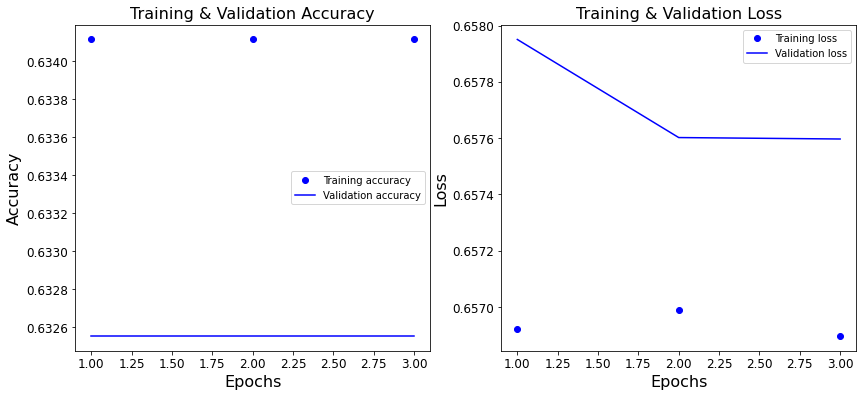

In [41]:
# This code sourced from the website below
# https://vitalflux.com/python-keras-learning-validation-curve-classification-model/

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
fit_data = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=3,
                    batch_size=1,
                    verbose=1)

model_dict = fit_data.history
loss_values = model_dict['loss']
val_loss_values = model_dict['val_loss']
accuracy = model_dict['accuracy']
val_accuracy = model_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [40]:
print(model_dict)

{'loss': [0.6567673087120056, 0.6567881107330322, 0.6567769050598145, 0.656779944896698], 'accuracy': [0.634115993976593, 0.634115993976593, 0.634115993976593, 0.634115993976593], 'val_loss': [0.6576083898544312, 0.6575921773910522, 0.6575875282287598, 0.6575829386711121], 'val_accuracy': [0.6325529217720032, 0.6325529217720032, 0.6325529217720032, 0.6325529217720032]}


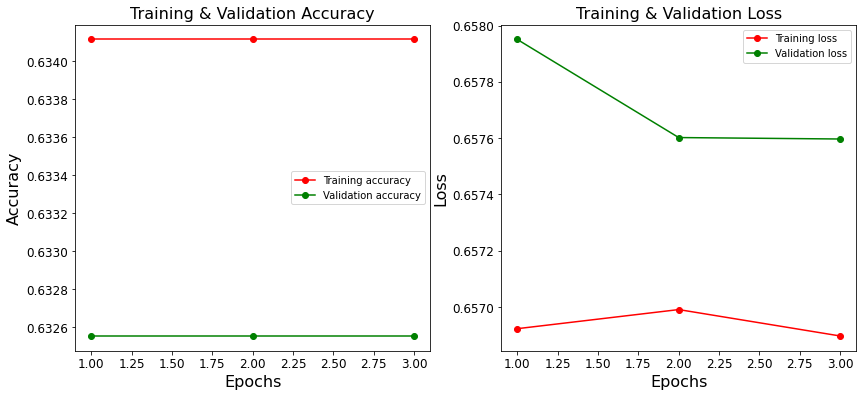

In [45]:
# This code sourced from site below
# https://vitalflux.com/python-keras-learning-validation-curve-classification-model/

model_dict = fit_data.history
loss_values = model_dict['loss']
val_loss_values = model_dict['val_loss']
accuracy = model_dict['accuracy']
val_accuracy = model_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'o-', color='r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'o-', color='g', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'o-', color='r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'o-', color='g', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

### Model improvement: Random Forest Classifier

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state = 0)

# Random forest classifier using 10 entropy trees
clf = RandomForestClassifier(n_estimators = 10,
                            random_state=0, criterion="entropy").fit(X_train, y_train)

print('Random Forest, Housing dataset, entropy tree with 10 trees')
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))
print()

# Random forest classifier using 10 gini trees
clf = RandomForestClassifier(n_estimators = 10,
                            random_state=0, criterion="gini").fit(X_train, y_train)

print('Random Forest, Housing dataset, gini tree with 10 trees')
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))
print()

# Random forest classifier using 100 entropy trees
clf = RandomForestClassifier(n_estimators = 100,
                            random_state=0, criterion="entropy").fit(X_train, y_train)

print('Random Forest, Housing dataset, entropy tree with 100 trees')
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))
print()

# Random forest classifier using 100 gini trees
clf = RandomForestClassifier(n_estimators = 100,
                            random_state=0, criterion="gini").fit(X_train, y_train)

print('Random Forest, Housing dataset, gini tree with 100 trees')
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Random Forest, Housing dataset, entropy tree with 10 trees
Accuracy of RF classifier on training set: 0.98
Accuracy of RF classifier on test set: 0.79

Random Forest, Housing dataset, gini tree with 10 trees
Accuracy of RF classifier on training set: 0.98
Accuracy of RF classifier on test set: 0.79

Random Forest, Housing dataset, entropy tree with 100 trees
Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.81

Random Forest, Housing dataset, gini tree with 100 trees
Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.81


In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold # import k-fold validation

# Using random forest classifier with 100 entropy trees
clf = RandomForestClassifier(n_estimators = 100,
                            random_state=0, criterion="entropy").fit(X_train, y_train)

# k-fold cross validation (k=10)
kf = KFold(n_splits=10, random_state=None, shuffle=True) # Define the split - into 2 folds
precision_sum = recall_sum = accuracy_sum = 0

# DataFrame for storing validation metrics
metrics_df = pd.DataFrame(columns = ['precision', 'recall', 'accuracy'])

# each fold
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    # Print classification report
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    result_metrics_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    
    precision_sum += result_metrics_dict["macro avg"]["precision"]
    recall_sum += result_metrics_dict["macro avg"]["recall"]
    accuracy_sum += result_metrics_dict["accuracy"]
    
    # Store metrics data for later analysis
    metrics_list = []
    metrics_list.append(result_metrics_dict["macro avg"]["precision"])
    metrics_list.append(result_metrics_dict["macro avg"]["recall"])
    metrics_list.append(result_metrics_dict["accuracy"])
    
    metrics_series = pd.Series(metrics_list, index=metrics_df.columns)
    metrics_df = metrics_df.append(metrics_series, ignore_index=True)

print("Average precision (ENTROPYx100):", precision_sum/kf.get_n_splits(X))
print("Average recall (ENTROPYx100):", recall_sum/kf.get_n_splits(X))
print("Average accuracy (ENTROPYx100):", accuracy_sum/kf.get_n_splits(X))

# os.makedirs('./MLP3_data', exist_ok=True)
metrics_df.to_csv('./MLP3_data/randomforest_metrics.csv')

              precision    recall  f1-score   support

       Under       0.84      0.85      0.84      1415
        Over       0.71      0.69      0.70       747

    accuracy                           0.79      2162
   macro avg       0.77      0.77      0.77      2162
weighted avg       0.79      0.79      0.79      2162

              precision    recall  f1-score   support

       Under       0.82      0.86      0.84      1376
        Over       0.73      0.68      0.70       786

    accuracy                           0.79      2162
   macro avg       0.78      0.77      0.77      2162
weighted avg       0.79      0.79      0.79      2162

              precision    recall  f1-score   support

       Under       0.83      0.86      0.84      1382
        Over       0.73      0.69      0.71       780

    accuracy                           0.80      2162
   macro avg       0.78      0.77      0.78      2162
weighted avg       0.80      0.80      0.80      2162

              preci